In [41]:
# Import the necessary modules
from os import path as op
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
from rasterio.features import geometry_window
import rasterstats
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti
from osgeo import gdal

In [14]:
#Read in the training dataset, its in geojson format
training_vectors = gpd.read_file('training_data.geojson')
training_vectors.head()

,name,description,geometry
0,Shadow,None,"MULTIPOLYGON (((34.83383 1.18204, 34.83577 1.1..."
1,Forestland,None,"MULTIPOLYGON (((35.30961 1.01328, 35.30964 1.0..."
2,Maize,early reproductive,"MULTIPOLYGON (((34.90904 1.09515, 34.90907 1.0..."
3,Sugarcane,no change..maize farm on the right and far lef...,"MULTIPOLYGON (((34.90750 1.08934, 34.90753 1.0..."
4,Maize,reproductive good crop,"MULTIPOLYGON (((34.87144 0.82953, 34.87147 0.8..."


In [15]:
#Display the unique Landcover classes names
classes = training_vectors['name'].unique()
classes

array(['Shadow', 'Forestland', 'Maize', 'Sugarcane', 'Sunflower', 'Cloud',
       'Waterbody', 'Grassland', 'Built', 'Fallow'], dtype=object)

In [16]:
# create a dictionary to convert lancover classes into integers for modeling
# To create dictionary from two sequences
class_dict = dict(zip(classes, range(len(classes))))
class_dict 

{'Shadow': 0,
 'Forestland': 1,
 'Maize': 2,
 'Sugarcane': 3,
 'Sunflower': 4,
 'Cloud': 5,
 'Waterbody': 6,
 'Grassland': 7,
 'Built': 8,
 'Fallow': 9}

In [17]:
#Rasterize Geometries

dst = rasterio.open('Trans_nzoia_2019_05-02.tif', 'r')

#Create two empty lists
#Independent and dependent variables
X_raw = []
y_raw = []

for (label, geom) in zip(training_vectors.name, training_vectors.geometry):
    
    #Read the raster data matching the geometry bounds
    window = bounds_window(geom.bounds, dst.transform)
    #Store our windows information
    window_affine = dst.window_transform(window)
    frsc = dst.read(window=window)
    
    #Rasterize geometries
    mask = rasterize([(geom,1)],
                   out_shape=frsc.shape[1:],
                   transform=window_affine,
                   fill=0,
                   dtype='uint8',
                   all_touched=True,
                   ).astype(bool)
    
    label_pixels = np.argwhere(mask)
    
    for (row, col) in label_pixels:
        #add a pixel of data to X
        data = frsc[:, row, col]
        one_x = np.nan_to_num(data, nan = 1e-3)
        X_raw.append(one_x)
        #add the label to y
        y_raw.append(class_dict[label])

In [18]:
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

((160461, 6), (160461,))

In [20]:
# helper function for calculating ND*I indices (bands in the final dimension)
def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

ndvi = band_index(X, 3, 2)
ndwi = band_index(X, 1, 3)

X = np.concatenate([X, ndvi, ndwi], axis=1)
X.shape

(160461, 8)

In [22]:
#Create a Pandas Dataframe out of the independent and independent variables
X = pd.DataFrame(X, dtype= 'float32')
y = pd.DataFrame(y, dtype= 'float32')
X.head()

,0,1,2,3,4,5,6,7
0,0.0946,0.0921,0.10015,0.20350,0.25380,0.17655,0.340359,-0.376861
1,0.0958,0.0928,0.10310,0.20965,0.25585,0.17420,0.340687,-0.386345
2,0.0979,0.1022,0.11020,0.22000,0.25585,0.17420,0.332526,-0.365611
3,0.0941,0.0938,0.09850,0.21530,0.25915,0.17555,0.372212,-0.393077
4,0.0955,0.0949,0.09940,0.21595,0.25915,0.17555,0.369589,-0.389416


In [24]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
# Calcualte class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
# Landcover classes and their corresponding frequencies.
frequencies = np.asarray((labels, counts)).T
class_weight_dict = dict(zip(labels, 1 / counts))
(frequencies, class_weight_dict)

(array([[0.0000e+00, 3.5270e+03],
        [1.0000e+00, 4.4389e+04],
        [2.0000e+00, 5.5754e+04],
        [3.0000e+00, 3.0820e+03],
        [4.0000e+00, 1.7000e+01],
        [5.0000e+00, 5.5000e+02],
        [6.0000e+00, 2.8600e+02],
        [7.0000e+00, 1.0580e+03],
        [8.0000e+00, 1.8860e+03],
        [9.0000e+00, 1.7730e+03]]),
 {0.0: 0.0002835270768358378,
  1.0: 2.2528103809502354e-05,
  2.0: 1.7935932847867417e-05,
  3.0: 0.0003244646333549643,
  4.0: 0.058823529411764705,
  5.0: 0.0018181818181818182,
  6.0: 0.0034965034965034965,
  7.0: 0.000945179584120983,
  8.0: 0.0005302226935312832,
  9.0: 0.0005640157924421884})

In [26]:
# importing Algorithms to fit model and predict Output
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [27]:
# creating list of tuple wth model and its name  
models = []
models.append(('GNB',GaussianNB()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('DT',DecisionTreeClassifier()))
models.append(('RF',RandomForestClassifier()))
models.append(('LG',LogisticRegression(max_iter=3000)))
models.append(('SVC',SVC()))

In [38]:
from sklearn.model_selection import cross_val_score

acc = []   # list for collecting Accuracy of all model
names = []    # List of model name

for name, model in models:
    acc_of_model = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro')
    # appending F1_Scores of different model to acc List
    acc.append(acc_of_model)
    # appending name of models
    names.append(name)
    # printing Output 
    Out = "%s: %f" % (name, acc_of_model.mean())
    print(Out)

C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\utils\vali

GNB: 0.419928


C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\neighbors\

KNN: 0.723389
DT: 0.701039


C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Abu Bakar\Dow

RF: 0.751935


C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\utils\vali

LG: 0.307580


C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Abu Bakar\Downloads\WPy64-31020\python-3.10.2.amd64\lib\site-packages\sklearn\utils\vali

SVC: 0.357958


In [28]:
#Random Forest provides highest prediction accuracy
# initialize a RandomForestClassifier
RF = RandomForestClassifier(n_estimators=200, class_weight=class_weight_dict, max_depth=6, n_jobs=-1, verbose=1, random_state=0)
RF.fit(X_train, y_train)

C:\Users\Abu Bakar\AppData\Local\Temp\ipykernel_4032\148201180.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train, y_train)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.0s finished


RandomForestClassifier(class_weight={0.0: 0.0002835270768358378,
                                     1.0: 2.2528103809502354e-05,
                                     2.0: 1.7935932847867417e-05,
                                     3.0: 0.0003244646333549643,
                                     4.0: 0.058823529411764705,
                                     5.0: 0.0018181818181818182,
                                     6.0: 0.0034965034965034965,
                                     7.0: 0.000945179584120983,
                                     8.0: 0.0005302226935312832,
                                     9.0: 0.0005640157924421884},
                       max_depth=6, n_estimators=200, n_jobs=-1, random_state=0,
                       verbose=1)

In [29]:
y_pred = RF.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.2s finished


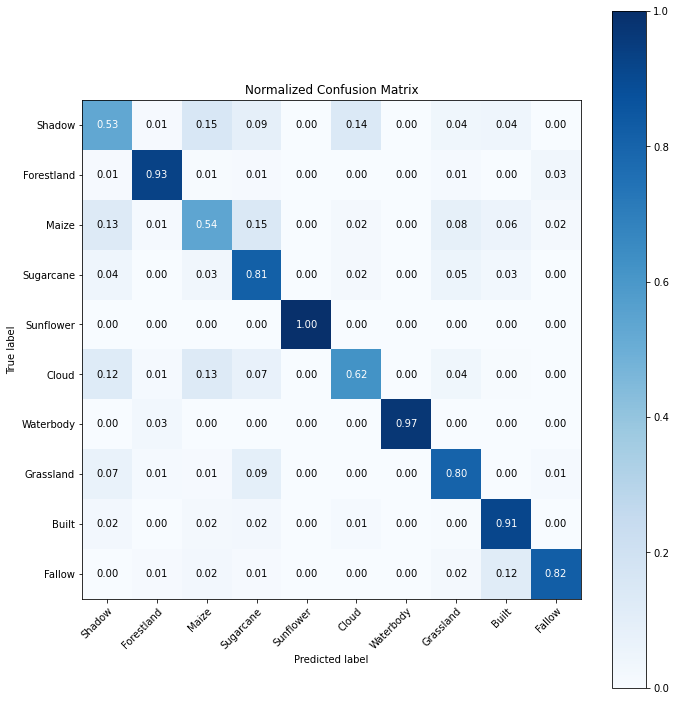

In [30]:
# plot the confusion matrix
%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

In [31]:
# save the trained model as pickle file
model_name = 'random_forest.sav'
with open(model_name, 'wb') as modelfile:
    pickle.dump(RF, modelfile)

## Inference

In [39]:
#User define Function to save the Geotiff
def createGeotiff(outRaster, estimation_array, geo_transform, projection):
    driver = gdal.GetDriverByName('GTIFF')
    rows, cols = estimation_array.shape
    rasterDS = driver.Create(outRaster, cols, rows, 1, gdal.GDT_Float32)
    rasterDS.SetGeoTransform(geo_transform)
    rasterDS.SetProjection(projection)
    band = rasterDS.GetRasterBand(1)
    band.WriteArray(estimation_array)
    rasterDS= None

In [2]:
# To apply the model on the whole raster
with rasterio.open('Trans_nzoia_2019_05-02.tif', 'r') as dataset:
    profile = dataset.profile
    bands_read = dataset.read(masked = True)
    band = np.array(bands_read, dtype='float32')
    
print('No of Bands =', dataset.count)
print('CRS Projection =', dataset.crs)
print('Dataset Indexes = ', dataset.indexes)

No of Bands = 6
CRS Projection = EPSG:4326
Dataset Indexes =  (1, 2, 3, 4, 5, 6)


In [42]:
geo_transform = dataset.GetGeoTransform()
projection = dataset.GetProjectionRef()

AttributeError: 'DatasetReader' object has no attribute 'GetGeoTransform'

In [19]:
(dataset.height, dataset.width)

(5343, 8671)

In [4]:
# Calcualte the two vegetation indices
# NDVI (NIR - Red) / (NIR + Red)
NDVI = (band[3].astype('float32') - band[2].astype('float32')) / (band[3] + band[2])
NDWI = (band[1].astype('float32') - band[3].astype('float32')) / (band[1] + band[3])

In [7]:
band.shape

(6, 5343, 8671)

In [8]:
array = np.stack(band[:,:,:], axis= 2)
array.shape

(5343, 8671, 6)

In [9]:
#Remember: we need a 2D array of size [n_samples x n_features] for Sk-learn
#Convert the 3d stack array into 2D
array = np.reshape(array, [dataset.height*dataset.width, dataset.count])
array.shape

(46329153, 6)

In [10]:
arr_NDVI = np.reshape(NDVI, [dataset.height*dataset.width, 1])
arr_NDWI = np.reshape(NDWI, [dataset.height*dataset.width, 1])
(arr_NDVI.shape, arr_NDWI.shape)

((46329153, 1), (46329153, 1))

In [11]:
al = np.concatenate([array, arr_NDVI, arr_NDWI], axis=1)
al.shape

(46329153, 8)

In [12]:
#Remove no datavalues
m = np.ma.masked_invalid(al)
to_predict = al[~m.mask].reshape(-1, al.shape[-1])

In [13]:
to_predict.shape

(24973531, 8)

In [14]:
#Create a pandas dataframe
test = pd.DataFrame(to_predict, dtype= 'float32')
test.head()

,0,1,2,3,4,5,6,7
0,0.1004,0.1078,0.1201,0.2355,0.3028,0.2151,0.324522,-0.371978
1,0.0950,0.0975,0.0947,0.2242,0.2911,0.2115,0.406083,-0.393845
2,0.0983,0.1063,0.1097,0.2176,0.2911,0.2115,0.329667,-0.343625
3,0.1035,0.1078,0.1195,0.2489,0.3249,0.2319,0.351249,-0.395570
4,0.1058,0.1105,0.1270,0.2436,0.3200,0.2295,0.314625,-0.375883


In [15]:
#Load the saved model
RF = pickle.load(open('random_forest.sav', 'rb'))
pred = RF.predict(test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed: 30.9min
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed: 33.4min finished


In [35]:
output[~m.mask[:, 0]] = pred.flatten()

In [36]:
estimation = output.reshape((dataset.height, dataset.width))

In [37]:
estimation.shape

(5343, 8671)

In [44]:
#Save the newly generated raster (classified raster) as geotiff
with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = dataset.profile

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='lzw')

    with rasterio.open('classification.tif', 'w', **profile) as dst:
        dst.write(estimation.astype(rasterio.uint8), 1)